<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Partie_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are female, politicians like any other ? 

## Part I : Corpus analysis

### Downloading packages

In [0]:
!python -m spacy download fr_core_news_md
import nltk
nltk.download('punkt')

In [0]:
import spacy
from funct import *
import nltk
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import add
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from os import path
from PIL import Image
import funct
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
nlp = spacy.load('fr_core_news_md') 
import multiprocessing as mp
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from sklearn import utils
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    scorer)
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_palette("husl")

We import our corpus in the notebook. This corpus has been scrapped from : https://www.vie-publique.fr/discours.

In [0]:
df = pd.read_csv('medium_df_deseq.csv')
df.head()

,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte,Lien,PRENOM,preusuel,sexe
0,10504,144565,"Déclaration de M. Jacques Chirac, Président de...",déclaration,International,Jacques,Chirac,NaN,1998-10-03T12:00:00Z,"Défense,Politique de la défense","Messieurs,Je suis heureux de vous saluer. Quan...",https://www.vie-publique.fr/discours/144565-de...,JACQUES,JACQUES,1
1,3304,196091,"Déclaration de M. Laurent Fabius, ministre des...",déclaration,Société,Laurent,Fabius,NaN,2015-08-26T12:00:00Z,"Environnement,Climat",Tout ce que nous avons entendu au cours de cet...,https://www.vie-publique.fr/discours/196091-de...,LAURENT,LAURENT,1
2,8816,128510,"Déclaration de M. François Hollande, premier s...",déclaration,Institutions,François,Hollande,NaN,2002-03-14T12:00:00Z,"Citoyenneté - Elections,Personnalité politique","Cher(e)s Ami(e)s, Cher(e)s Camarades, C'est av...",https://www.vie-publique.fr/discours/128510-de...,FRANÇOIS,FRANÇOIS,1
3,19491,140697,"Déclaration de M. Alain Lambert, ministre délé...",déclaration,International,Alain,Lambert,NaN,2003-06-11T12:00:00Z,"Relations internationales,Frontière","Mesdames,messieurs, C'est avec grand plaisir q...",https://www.vie-publique.fr/discours/140697-de...,ALAIN,ALAIN,1
4,6289,195589,"Déclaration de M. François Hollande, Président...",déclaration,International,François,Hollande,NaN,2015-07-03T12:00:00Z,"Relations internationales,Relations bilatérale...","Mesdames, Messieurs, bonsoir - j'allais dire b...",https://www.vie-publique.fr/discours/195589-de...,FRANÇOIS,FRANÇOIS,1


### Some basic external statistics

We clean the encoding of the text as a first treatment. 

In [0]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80',''))
df.Texte = df.Texte.apply(remove_source)

In [0]:
print('On average, text length is {}'.format(round(df.Texte.apply(len).mean())))

On average, text length is 11571


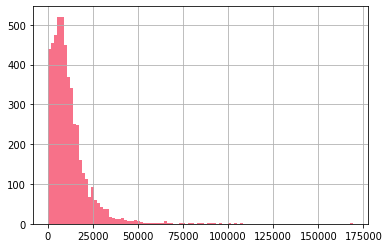

In [0]:
%matplotlib inline
df.Texte.apply(len).hist(bins=100)
plt.show()

#### Speakers gender proportions

In [0]:
print('The corpus gathers {} political speeches' .format(len(df)))
print('There are {} male speakers and {} female speakers'.format(df.sexe.map(str).value_counts()[0],df.sexe.map(str).value_counts()[1]))

The corpus gathers 5000 political speeches
There are 3750 male speakers and 1250 female speakers


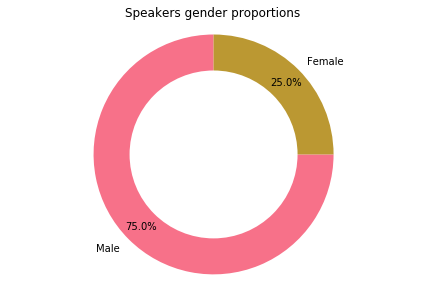

In [0]:
labels = ['Male','Female']
#colors = ['#ffcc99','#ff9999']
sizes = [ len(df[df.sexe ==1]),len(df[df.sexe ==2])]
fig, ax1 = plt.subplots()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Speakers gender proportions")
plt.show()

Without surprise we have an unbalanced corpus with men being much more represented than women.

#### Speakers gender through time 

One of the very nice feature of our corpus is that we have access to almot all government speeches and interview from 1990. Let's see how the proportion of women and men in the corpus changed through years. 

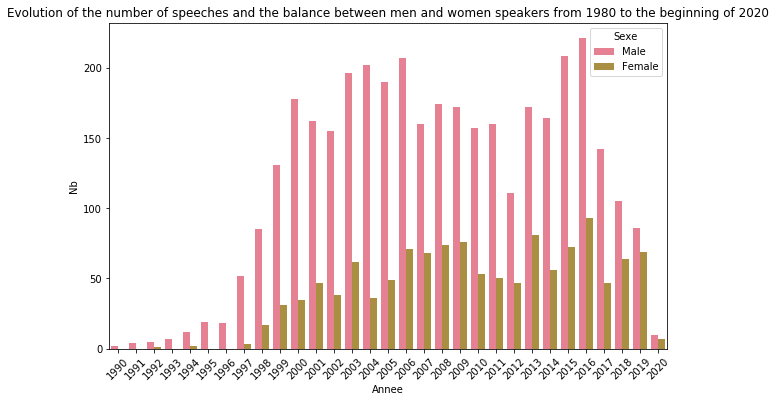

In [0]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Male'
        else:
            sexe='Female'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])
data=data[data['Annee']>='1990']
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution of the number of speeches and the balance between men and women speakers from 1980 to the beginning of 2020")
plt.show()

We definitely see an increase in the absolute number of female speakers. However the gap is still important. 
In 2019 we see that eventually the number of male and female speakers are really close. 

####  Speaker's gender and speeches general theme

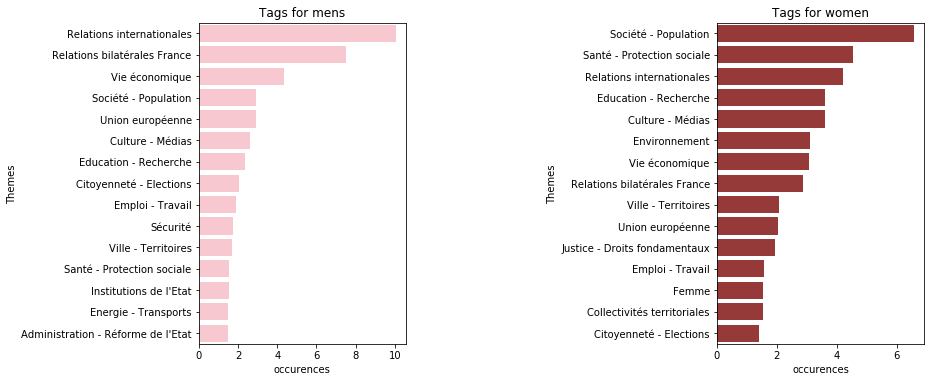

In [0]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
d = pd.concat([d_f,d_m])
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 0.5) & (d.Themes.apply(len) >0) & (d.sexe == 'Male')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color='pink')
plt.title("Tags for mens")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 0.6) & (d.Themes.apply(len) >0) & (d.sexe == 'Female')].sort_values('occurences',ascending=False).head(15),
            y='Themes',
            x='occurences',
           color = 'brown')
plt.title("Tags for women")
plt.subplots_adjust(wspace = 1.5)

Men and women are not talking about the same subjects. If women are more likely to speak about Society and Health, men are more likely to speak about international relations and economics. 

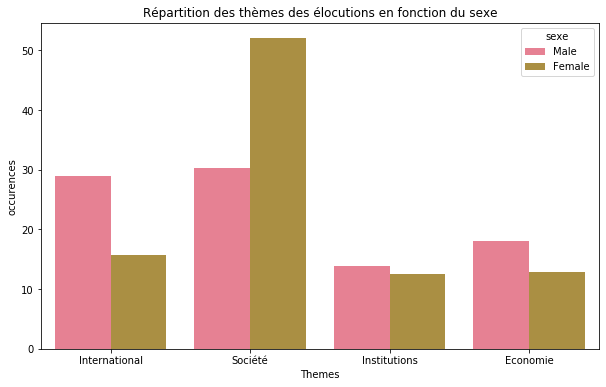

In [0]:
df.Theme.fillna('',inplace=True)
arr =df[df.sexe == 1].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m.occurences = d_m.occurences.apply(lambda x:(x/d_m.occurences.sum())*100)
d_m['sexe'] = 'Male'
arr =df[df.sexe == 2].Theme.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f.occurences = d_f.occurences.apply(lambda x:(x/d_f.occurences.sum())*100)
d_f['sexe'] = 'Female'
d = pd.concat([d_m,d_f])
plt.figure(figsize=(10,6))
sns.barplot(data = d[d.Themes != ''],hue = 'sexe',x='Themes',y='occurences')
plt.title('Répartition des thèmes des élocutions en fonction du sexe')
plt.xticks(rotation=0)
plt.show()

We represent the same chart but with a lower level of granularity in themes. The same conclustion can be drawn. 

After this brief introduction we will dive into our texts. The next section focuses on cleaning and preprocessing our texts. We will try to construct some quantitative metrics that could be , in our opinion, explanatory features to differenciate female and male speakers. 


### Word-level preprocessing

Let's try different tokenizers ! 

In [0]:
tokenizer = Tokenizer(nlp.vocab)
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

In [0]:
print(len([w for w in tokenizer(df.Texte[0])]))

1702


In [0]:
([w for w in tokenizer(df.Texte[0])])[0:10]

[Messieurs,Je, suis, heureux, de, vous, saluer., Quand, je, dis, que]

In [0]:
print(len(word_tokenize(df.Texte[0], language='french')))

1932


In [0]:
word_tokenize(df.Texte[0], language='french')[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [0]:
print(len(toknizer.tokenize(df.Texte[0])))

2135


In [0]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

In [0]:
toknizer.tokenize(df.Texte[0])[0:10]

['Messieurs',
 ',',
 'Je',
 'suis',
 'heureux',
 'de',
 'vous',
 'saluer',
 '.',
 'Quand']

The NLTK tokenizer tokenizes punctuation whereas the spacy one does not. We decide to switch to the NLTK tokenizer.

In [0]:
print('Length of spacy stopwords list is {} and length of NLTK stopwords list is {} '.format(len(list(fr_stop)),len(stopwords.words('french'))))

Length of spacy stopwords list is 602 and length of NLTK stopwords list is 157 


In [0]:
As the NLTK sent detector is far from being optimal we tried to detect sentences with the 'sent_detector_mano' function which seems to work much better on our corpus.

We also added a way to clean the 
politeness formulation like 'Madame' or 'Monsieur' because they always occur in the beggining of our document.

In [0]:
df['NbToken'] = df.Texte.apply(lambda x : len(word_tokenize(x,language='french')))
df['Token'] = df.Texte.apply(lambda x : word_tokenize(x,language='french'))

In [0]:
lst_nom = [nom for nom in set(df.Nom+ ' ' +df.Prenom) if nom not in 'ministère'] + [nom for nom in set(df.Prenom+ ' ' +df.Nom) if nom not in 'ministère']+ [nom for nom in set(df.Prenom) if nom != 'ministère'] + [nom for nom in set(df.Nom) if nom != 'ministère']
cleanFast = lst_nom + ['Mr','M','Mme','Madame','Monsieur','monsieur','madame','mme','mr','mesdames','messieurs']

In [0]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


add_features()
Usefull for parallel processing
Input : DataFrame
Output : DataFrame with new columns created

para_df()
Parralelisation
Input : 
      df : DataFrame
      func : function to return data
      n_cores : number of cores
Output : 
      df with new columns
  """

In [0]:
def add_features(df):
    from multiprocessing import Pool
    nlp = spacy.load('fr_core_news_md') 
    df['NbCleanToken'] = df.Texte.apply(lambda x : len(cleanToken(x)))
    df['NbSyllables'] = df.Texte.apply(NbSyllables)
    df['NbMot'] = df.Texte.apply(extraire_nb_mot)
    df['Phrases'] = df.Texte.apply(sent_detector_mano)
    df['NbPhrases'] = df.Texte.apply(lambda x:len(sent_detector_mano(x)))
    df['CleanToken'] = df.Texte.apply(cleanToken)
    df.CleanToken = df.apply(lambda row : FastCleaner(row.CleanToken,cleanFast),axis=1)
    df['NbCleanToken']=df.CleanToken.apply(len)
    df['NbPonct'] = df.Texte.apply(count_punct)
    df['NbSw'] = df.Token.apply(count_stopwords)
    df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
    df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
    df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))
    #df['RateCleanRaw'] = df.NbCleanToken/df.NbToken
    df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
    df['NbArt']= df.Texte.apply(nbArt)
    df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)
    df['PronJe']=df.apply(lambda row : Pron_Type(row.Texte,nlp),axis=1)
    df['PronNous']=df.apply(lambda row : Pron_Type_Plur(row.Texte,nlp),axis=1)
    df['NbPres'],df['NbPast'],df['NbFut'],df['NbImp']  = zip(*df.apply(lambda row : Verb_Tens(row.Texte,nlp),axis=1))
    df['NbQuest']= df.apply(lambda row : Quest(row.Texte,nlp),axis=1)
    df['NbExcl']= df.apply(lambda row  : Excl(row.Texte,nlp),axis=1)
    return df
def para_df(df,func,n_cores = mp.cpu_count()):
    from multiprocessing import Pool
    df_split = np.array_split(df,n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func,df_split))
    pool.close()
    pool.join()
    return df

In [0]:
df['NbNom'],df['NbDet'],df['NbPunct'],df['NbAdj'],df['NbAdp'],df['NbPron'],df['NbVerb'],df['NbCconj'],df['NbNum'],df['NbPropn'],df['NbAdv'],df['NbSCONJ'],df['NbAUX'],df['NbIntj']=zip(*df.Texte.apply(extractPos))
 

In [0]:
df['NbMot'] = df.Texte.apply(extraire_nb_mot)

In [0]:
df['PronJe']=df.apply(lambda row : Pron_Type(row.Texte,nlp),axis=1)
df['PronNous']=df.apply(lambda row : Pron_Type_Plur(row.Texte,nlp),axis=1)
#Mettre tout en meme temps 

In [0]:
df['NbPres'],df['NbPast'],df['NbFut'],df['NbImp']  = zip(*df.apply(lambda row : Verb_Tens(row.Texte,nlp),axis=1))
df['NbQuest']= df.apply(lambda row : Quest(row.Texte,nlp),axis=1)
df['NbExcl']= df.apply(lambda row  : Excl(row.Texte,nlp),axis=1)

In [0]:
df['NbArt']= df.Texte.apply(nbArt)
df['F_mesure'] = df.apply(lambda row: f_mesure(row.NbToken,row.NbNom,row.NbAdj,row.NbAdp,row.NbArt,row.NbPron,row.NbVerb,row.NbAdv,row.NbIntj),axis=1)

In [0]:
df['CleanToken'] = df.Texte.apply(cleanToken)
df['Hapaxlegomena']=df.CleanToken.apply(Hapaxlegomena)
df['Hapaxdislegomena']= df.CleanToken.apply(Hapaxdislegomena)
df['UniqueWordTx']= df.CleanToken.apply(lambda x:len(set(x))/len(x))

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['Hapaxlegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxlegomena'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['Hapaxdislegomena'])
sns.distplot(df[df.sexe == 1]['Hapaxdislegomena'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['UniqueWordTx'])
sns.distplot(df[df.sexe == 1]['UniqueWordTx'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['F_mesure'])
sns.distplot(df[df.sexe == 1]['F_mesure'])
plt.show()

In [0]:
#df = para_df(df,add_features)

In [0]:
df[['NbNom_prec']]=df[['NbNom']].div(df.NbMot,axis=0)

df[['NbDet_prec']]=df[['NbDet']].div(df.NbMot,axis=0)

df[['NbAdj_prec']]=df[['NbAdj']].div(df.NbMot,axis=0)

df[['NbPron_prec','NbVerb_perc','NbAUX_perc']]=df[['NbPron','NbVerb','NbAUX']].div(df.NbMot,axis=0)

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbNom_prec'])
sns.distplot(df[df.sexe == 1]['NbNom_prec'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbAdj_prec'])
sns.distplot(df[df.sexe == 1]['NbAdj_prec'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['NbPron_prec'])
sns.distplot(df[df.sexe == 1]['NbPron_prec'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['NbVerb_perc'])
sns.distplot(df[df.sexe == 1]['NbVerb_perc'])
plt.show()

More over, what is interresting to observe is what type of pronoum women and men use.


In [0]:
lst=[ 'NbSyllables','NbPhrases','NbMot','NbToken','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 
       'UniqueWordTx', 'RateCleanRaw','NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb',
        'NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','NbArt', 'F_mesure'
        ]
lst = lst + ['NbNom_prec','NbDet_prec','NbAdj_prec',
    'NbPron_prec','NbVerb_perc','NbAUX_perc']
df[['PronJe_perc','PronNous_perc']]=df[['PronJe','PronNous']].div(df.NbMot,axis=0)
lst = lst + ['PronJe_perc','PronNous_perc']
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['PronJe_perc'])
sns.distplot(df[df.sexe == 1]['PronJe_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['PronNous_perc'] )
sns.distplot(df[df.sexe == 1]['PronNous_perc'])
plt.show()

De plus grosses différences sur le j en terme de distr mais une queue de distribution plus importante pour les nous en bas ( à voir finalement si je divise par le nombre de pronom pas vraiment. 

In [0]:
df[['NbQuest_perc','NbExcl_perc']]=df[['NbQuest','NbExcl']].div(df.NbToken,axis=0)
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['NbQuest_perc'])
sns.distplot(df[df.sexe == 1]['NbQuest_perc'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['NbExcl_perc'])
sns.distplot(df[df.sexe == 1]['NbExcl_perc'])
plt.show()

### Sentiment extraction using FEEL (French Expanded Emotion Lexicon)

http://advanse.lirmm.fr/feel.php

In [0]:
feel = pd.read_csv('FEEL.csv',sep=';')
feel.set_index('id',inplace=True)
feel.sample(10)

In [0]:
extraction_emotion(cleanTokenLemme(df.Texte[0],cleanFast))

In [0]:
check_polarity(cleanTokenLemme(df.Texte[0],cleanFast))

In [0]:
def add_features2(df):
    """
    Sert pour la parallélisation
    Input : DataFrame
    Output : DataFrame avec les nouvelles colonnes crée
  """
    df['CleanTokensLemme'] = df.apply(lambda row : cleanTokenLemme(row.Texte,cleanFast),axis=1)
    df['PolPos'],df['PolNeg'],df['PolUnk'] = zip(*df.CleanTokensLemme.apply(check_polarity))
    df['FreqJoie'],df['FreqPeur'],df['FreqSad'],df['FreqColere'],df['FreqSurprise'],df['FreqDegout'] = zip(*df.CleanTokensLemme.apply(extraction_emotion))
    return df

In [0]:
df['CleanTokensLemme'] = df.apply(lambda row : cleanTokenLemme(row.Texte,cleanFast),axis=1)
df['PolPos'],df['PolNeg'],df['PolUnk'] = zip(*df.CleanTokensLemme.apply(check_polarity))
df['FreqJoie'],df['FreqPeur'],df['FreqSad'],df['FreqColere'],df['FreqSurprise'],df['FreqDegout'] = zip(*df.CleanTokensLemme.apply(extraction_emotion))


In [0]:
#df = para_df(df,add_features2)

In [0]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
sns.distplot(df[df.sexe == 2]['FreqJoie'])
sns.distplot(df[df.sexe == 1]['FreqJoie'])
plt.subplot(2, 2, 2)
sns.distplot(df[df.sexe == 2]['FreqPeur'])
sns.distplot(df[df.sexe == 1]['FreqPeur'])
plt.subplot(2, 2, 3)
sns.distplot(df[df.sexe == 2]['FreqSad'])
sns.distplot(df[df.sexe == 1]['FreqSad'])
plt.subplot(2, 2, 4)
sns.distplot(df[df.sexe == 2]['FreqColere'])
sns.distplot(df[df.sexe == 1]['FreqColere'])
plt.show()


## Passons désormais au n-grams

Utilisation des tokens cleané et lemmatizer pour obtenir le n-gram
Il est possible de voir que le bi-gram ne semble par très pertinant au regard des mots qui ressortent et qui semble ne pas trop varier en fonction du sexe. 

Mo : Faudrait peut être même faire ca avant ? 

In [0]:
df.Texte = df.Texte.apply(lambda x : x.replace('\xa0','').replace('\x85','').replace('\x96','').replace('\x92',"'").replace('\x80','').replace('\xc3',''))
df.Texte = df.Texte.apply(remove_source)

In [0]:
from tqdm import tqdm
def tokenize_sent(corpus):
    tokenizer = Tokenizer(nlp.vocab)
    tokenized_sentences = []
    for sample in tqdm(corpus):
        for sentence in sent_detector.tokenize(sample):
            tokens = toknizer.tokenize(sentence)
            tokens = list(map(lambda x: x.lower(), tokens))
            tokenized_sentences.append(tokens)
    return tokenized_sentences

In [0]:
#toknizer.tokenize(sent_detector.tokenize(df.Texte[0])[0])

In [0]:
cleaned_corp = tokenize_sent(df.Texte.array)

In [0]:
from gensim.models.phrases import Phrases, Phraser

def show_phrases(tokenized_sentences, threshold=100, shown=15):
    phrases = Phrases(tokenized_sentences, threshold=threshold)
    i = 0
    for phrase, score in phrases.export_phrases(tokenized_sentences):
        if i>shown:
            break
        else:
            print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

In [0]:
show_phrases(cleaned_corp)

In [0]:
def clean_corpus(corpus, threshold=100):
    tokenized_sentences = tokenize_sent(corpus)
    phrases = Phrases(tokenized_sentences, threshold=threshold)
    phraser = Phraser(phrases)
    
    clean_corpus = []
    for sample in corpus:
        clean_corpus.append(phraser[sample])
    return clean_corpus

In [0]:
clean_corpus_gensim =clean_corpus(df.Token.array)

In [0]:
df['gensim']=pd.DataFrame([clean_corpus_gensim]).transpose()

In [0]:
# Metre le wordcloud après gensim 

In [0]:
import numpy as np
woman = np.array(Image.open("femme2.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=0.5, contour_color='black')
arr = reduce(add,df[df.sexe == 2].CleanToken.array)
corpus_f = ' '.join(arr)
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=1, contour_color='black')
arr = reduce(add,df[df.sexe == 1].CleanToken.array)
corpus_m = ' '.join(arr)
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

#Je veux pas faire la féministe mais ces dessins ? hahaha 
# Le truc c'est qu'il faut une silhouette en noir et blanc sinon c'est relou à corriger ! 

In [0]:
from nltk import ngrams
arr = df[df.sexe == 1].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
bigram_count = Counter(ngrams(arr, 2))

In [0]:
bigram_count.most_common(50)

In [0]:
arr = df[df.sexe == 2].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
bigram_count = Counter(ngrams(arr, 2))

In [0]:
bigram_count.most_common(50)

Passons aux tri-grams, on remarque déjà la présence toujours de personnes politiques (certains textes sont topés discours ou déclarations mais sont en réalité des interviews). Ensuite, on a énormément de (madame, monsieur + un titre), on supprime?

Mo : Pour l'analyse des features comme on le fait la oui on va enlever. Pour les N-grams il faudrait que trier avant et ne prend que les types de mots qui ne sont pas de sprénoms.

Mel : Update du 17/03, noramlement c'est bon

In [0]:
arr = df[df.sexe == 1].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
trigram_count = Counter(ngrams(arr, 3))

In [0]:
trigram_count.most_common(50)

In [0]:
arr = df[df.sexe == 2].CleanTokensLemme.array
arr = reduce(add,arr)
arr = ' '.join(arr)
arr = arr.split()
trigram_count = Counter(ngrams(arr, 3))

In [0]:
trigram_count.most_common(50)

In [0]:
import numpy as np
woman = np.array(Image.open("femme2.png"))
wc = WordCloud(background_color="white", max_words=100, mask=woman,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=0.5, contour_color='black')
arr = reduce(add,df[df.sexe == 2].CleanToken.array)
corpus_f = ' '.join(arr)
wc.generate(corpus_f)
man = np.array(Image.open("homme.png"))
wc2 = WordCloud(background_color="white", max_words=100, mask=man,
               stopwords=list(fr_stop)+["c'est","d'un","d'une","qu'il","n'est","j'ai","qu'elle"], contour_width=1, contour_color='black')
arr = reduce(add,df[df.sexe == 1].CleanToken.array)
corpus_m = ' '.join(arr)
wc2.generate(corpus_m)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(122)
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")

plt.show()

#Je veux pas faire la féministe mais ces dessins ? hahaha 
# Le truc c'est qu'il faut une silhouette en noir et blanc sinon c'est relou à corriger ! 

In [0]:
df.to_csv('minimal_df_var.csv')

# Baseline models: 

In order to make some modelization we only take a substract of the data.
We select two dataframes:


1.   One with balanced number of women and men
2.   Another umbalanced data witch respect the proportion of men/women

Both have same shapes (variable and length). 
We split our dataset in three part : 

*   Train : 80 %
*   Test : 20 %
*   Val :  10% of Test


We try different methods. The first is using features we extracted before from each document. Then, we try different form of word embedding which are TF-IDF,DBOW and DMM (different approch of Doc2Vec from the gensim package). 
Finally, we will try to combine word embeding and our extracted features.








In [0]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
df_deq = pd.read_csv('df_medium_deseq_var_5000.csv')

### First approch : Feature engineering

In [0]:
X = df_deq[['NbToken', 'NbSyllables', 'NbMot', 'NbPhrases','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 'UniqueWordTx', 'RateCleanRaw',
       'NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','PronJe', 'PronNous', 'NbPres', 'NbPast', 'NbFut', 'NbImp', 'NbQuest',
       'NbExcl', 'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]
y = df_deq.sexe.apply(lambda x : 1 if x == 2 else 0)


In [0]:
d=GaussianNB().fit(X_train,y_train)
pred = d.predict(X_test)
pred_prob = d.predict_proba(X_test)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,random_state = 42, test_size=0.1)

In [7]:
print(len(X_train),len(X_test),len(X_val))

4000 900 100


In [0]:
models  = [GaussianNB(),RandomForestClassifier(random_state=42),DecisionTreeClassifier(random_state=42),
          XGBClassifier(random_state = 42),LogisticRegression(random_state = 42,max_iter=1000),SVC(random_state = 42,probability=True)]

In [26]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.720000,0.067265,0.254237,0.106383,0.501136
RFC,0.763333,0.089686,0.666667,0.158103,0.537458
DTC,0.667778,0.372197,0.342975,0.356989,0.568669
XGBOOST,0.747778,0.080717,0.450000,0.136882,0.524111
SVC_linear,0.738889,0.049327,0.323529,0.085603,0.507677
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Classification report :               precision    recall  f1-score   support

           0       0.79      0.77      0.78       677
           1       0.34      0.37      0.36       223

    accuracy                           0.67       900
   macro avg       0.57      0.57      0.57       900
weighted avg       0.68      0.67      0.67       900

Accuracy :  0.6677777777777778
AUC :  0.5686688171900564


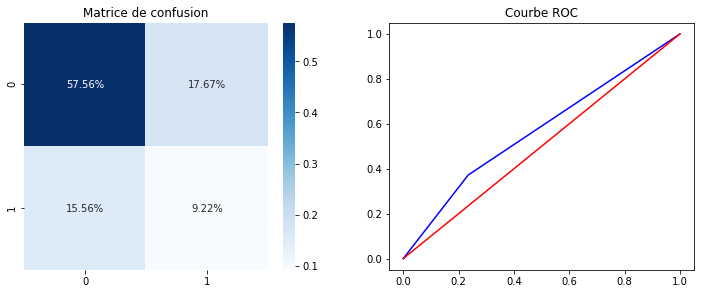

In [94]:
predictions(DecisionTreeClassifier(random_state=42),X_train,X_test,y_train,y_test)

### Second approch : TF-IDF

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,random_state = 42, test_size=0.1)

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop)
X = tfidfconverter.fit_transform(df_deq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,random_state = 42, test_size=0.1)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [128]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.741111,0.663677,0.483660,0.559546,0.715147
RFC,0.788889,0.170404,0.883721,0.285714,0.581509
DTC,0.730000,0.457399,0.455357,0.456376,0.638596
XGBOOST,0.830000,0.394619,0.830189,0.534954,0.684015
RegLog,0.812222,0.349776,0.764706,0.480000,0.657163
SVC_rbf,0.810000,0.340807,0.760000,0.470588,0.652678


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.87      0.77      0.82       677
           1       0.48      0.66      0.56       223

    accuracy                           0.74       900
   macro avg       0.68      0.72      0.69       900
weighted avg       0.78      0.74      0.75       900

Accuracy :  0.7411111111111112
AUC :  0.7151472799411809


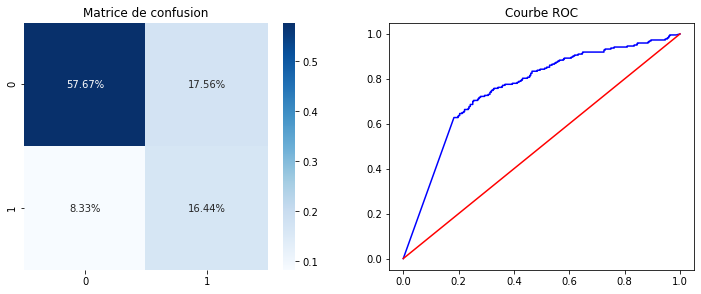

In [129]:
predictions(GaussianNB(),X_train,X_test,y_train,y_test)

In [161]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=fr_stop, ngram_range=(2,3))
X = tfidfconverter.fit_transform(df_deq['Texte']).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42 ,test_size =0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,random_state = 42, test_size=0.1)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [131]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train,X_test,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.731111,0.704036,0.471471,0.564748,0.722033
RFC,0.785556,0.273543,0.663043,0.387302,0.613876
DTC,0.674444,0.309417,0.331731,0.320186,0.552050
XGBOOST,0.782222,0.161435,0.800000,0.268657,0.574071
RegLog,0.800000,0.278027,0.765432,0.407895,0.624981
SVC_rbf,0.796667,0.264574,0.756410,0.392027,0.618254


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.88      0.74      0.81       677
           1       0.47      0.70      0.56       223

    accuracy                           0.73       900
   macro avg       0.68      0.72      0.69       900
weighted avg       0.78      0.73      0.75       900

Accuracy :  0.7311111111111112
AUC :  0.7220327082684754


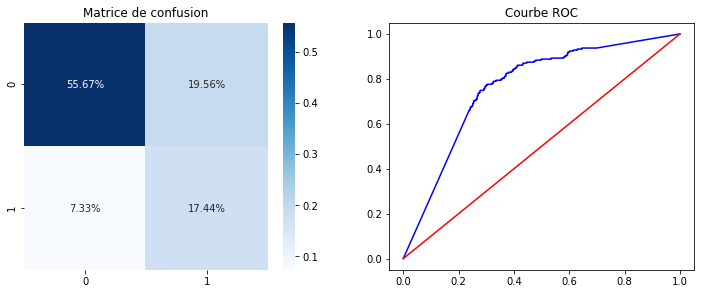

In [132]:
predictions(GaussianNB(),X_train,X_test,y_train,y_test)

### Third approch : 

We will now use a Distributed Bag of Words (DBOW) and a Distributed Memory (DMM) with some classical initialisation parameters. And we will tune them if the baseline model appear to be way better than others.


In [0]:
train,test = train_test_split(df_deq[['CleanTokensLemme','sexe']],random_state = 42 ,test_size =0.2)
test,val = train_test_split(test,random_state = 42, test_size=0.1)
train_tagged = train.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=r.CleanTokensLemme, tags=[r.sexe]), axis=1)

In [83]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=2)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 2931030.05it/s]


In [84]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 4000/4000 [00:00<00:00, 2745861.87it/s]


CPU times: user 15min, sys: 4.05 s, total: 15min 4s
Wall time: 7min 43s


In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_test_dbow, X_test_dbow = vec_for_learning(model_dbow, test_tagged)
y_train_dbow = pd.DataFrame(y_train_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dbow = pd.DataFrame(y_test_dbow,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)


In [0]:

X_train_dbow =  pd.DataFrame(X_train_dbow)
X_test_dbow =  pd.DataFrame(X_test_dbow)

In [87]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dbow,X_test_dbow,y_train_dbow,y_test_dbow)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.672222,0.192825,0.272152,0.225722,0.511479
RFC,0.748889,0.008969,0.285714,0.017391,0.500792
DTC,0.612222,0.251121,0.235294,0.242950,0.491144
XGBOOST,0.752222,0.008969,0.500000,0.017621,0.503007
SVC_linear,0.752222,0.000000,0.000000,0.000000,0.500000
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


In [0]:
for model in models:
  predictions(model,X_train_dbow,X_test_dbow,y_train_dbow,y_test_dbow)

In [75]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=2, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4000/4000 [00:00<00:00, 744991.83it/s]


In [76]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 4000/4000 [00:00<00:00, 2974156.36it/s]


CPU times: user 13min 8s, sys: 4.68 s, total: 13min 12s
Wall time: 6min 57s


In [0]:
y_train_dmm, X_train_dmm = vec_for_learning(model_dmm, train_tagged)
y_test_dmm, X_test_dmm = vec_for_learning(model_dmm, test_tagged)

In [0]:
y_train_dmm = pd.DataFrame(y_train_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)
y_test_dmm = pd.DataFrame(y_test_dmm,columns=['sexe']).sexe.apply(lambda x: 1 if x == 2 else 0)

X_train_dmm =  pd.DataFrame(X_train_dmm)
X_test_dmm =  pd.DataFrame(X_test_dmm)

In [80]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.650000,0.515695,0.357143,0.422018,0.604967
RFC,0.771111,0.107623,0.774194,0.188976,0.548642
DTC,0.634444,0.345291,0.296154,0.318841,0.537491
XGBOOST,0.770000,0.152466,0.653846,0.247273,0.562939
SVC_linear,0.764444,0.098655,0.666667,0.171875,0.541203
SVC_rbf,0.757778,0.035874,0.727273,0.068376,0.515722


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.81      0.69      0.75       677
           1       0.36      0.52      0.42       223

    accuracy                           0.65       900
   macro avg       0.59      0.60      0.59       900
weighted avg       0.70      0.65      0.67       900

Accuracy :  0.65
AUC :  0.6049671791271171


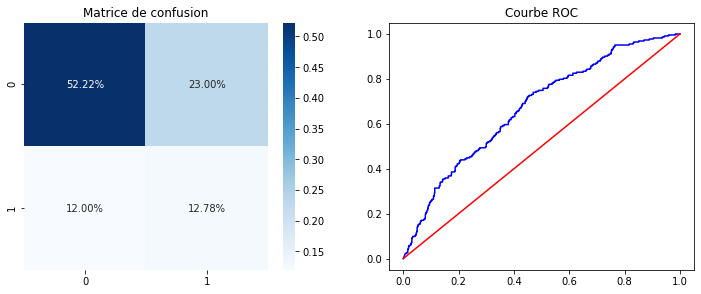

In [133]:
predictions(GaussianNB(),X_train_dmm,X_test_dmm,y_train_dmm,y_test_dmm)

### Combining two methods : Embeddings + features



In [0]:
X_train_idf_tri,X_test_idf_tri = pd.DataFrame(X_train),pd.DataFrame(X_test)
X = df_deq[['NbToken', 'NbSyllables', 'NbMot', 'NbPhrases','NbCleanToken', 'NbPonct', 'NbSw','Hapaxlegomena', 'Hapaxdislegomena', 'UniqueWordTx', 'RateCleanRaw',
       'NbNom', 'NbDet', 'NbPunct', 'NbAdj', 'NbAdp', 'NbPron', 'NbVerb','NbCconj', 'NbNum', 'NbPropn', 'NbAdv', 'NbSCONJ', 'NbAUX', 'NbIntj','PronJe', 'PronNous', 'NbPres', 'NbPast', 'NbFut', 'NbImp', 'NbQuest',
       'NbExcl', 'NbArt', 'F_mesure', 'NbNom_prec', 'NbDet_prec', 'NbAdj_prec','NbPron_prec', 'NbVerb_perc', 'NbAUX_perc', 'PronJe_perc','PronNous_perc', 'NbQuest_perc', 'NbExcl_perc',
       'PolPos', 'PolNeg', 'PolUnk', 'FreqJoie', 'FreqPeur', 'FreqSad','FreqColere', 'FreqSurprise', 'FreqDegout']]

In [0]:
X_train,X_test=train_test_split(X,random_state=42,test_size=0.2)
X_test,X_val=train_test_split(X_test,random_state=42,test_size=0.1)

In [0]:
idx = X_train.index
X_train_idf_tri = X_train_idf_tri.set_index(idx)
X_train_combine = pd.concat([X_train_idf_tri, X_train], axis=1)
idx=  X_test.index
X_test_idf_tri = X_test_idf_tri.set_index(idx)
X_test_combine = pd.concat([X_test_idf_tri, X_test], axis=1)

In [167]:
modeldf = pd.DataFrame(columns = [ 'Accuracy_score', 'Recall_score', 'Precision', 'f1_score',
       'Area_under_curve'])
for model in models:
    modeldf = pd.concat([modeldf,model_report(model,X_train_combine,X_test_combine,y_train,y_test)])
modeldf['nom']=['GaussianNB','RFC','DTC','XGBOOST','RegLog','SVC_rbf']
modeldf.set_index(['nom'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve
nom,,,,,
GaussianNB,0.740000,0.354260,0.467456,0.403061,0.610660
RFC,0.776667,0.152466,0.739130,0.252788,0.567371
DTC,0.690000,0.390135,0.378261,0.384106,0.589454
XGBOOST,0.773333,0.130045,0.743590,0.221374,0.557637
RegLog,0.741111,0.067265,0.375000,0.114068,0.515168
SVC_rbf,0.752222,0.000000,0.000000,0.000000,0.500000


GaussianNB(priors=None, var_smoothing=1e-09)
Classification report :               precision    recall  f1-score   support

           0       0.80      0.87      0.83       677
           1       0.47      0.35      0.40       223

    accuracy                           0.74       900
   macro avg       0.64      0.61      0.62       900
weighted avg       0.72      0.74      0.73       900

Accuracy :  0.74
AUC :  0.6106603254929754


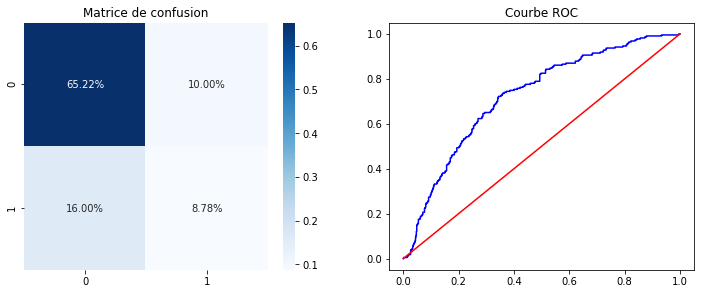

In [168]:
predictions(GaussianNB(),X_train_combine,X_test_combine,y_train,y_test)

## Conclusion on the umbalanced dataset

As we can see, the best method seem to be the TF-Idf tri-gram with a Naive Bayes model (with 0.5647 f1_score and a AUC of 0.72).
Moreover as we can see with the confusion matrix, the model is almost classying all the women correctly.
We will now try the same approch with a balanced dataset and after that we will try to tune the best model to extract some gender marker.

References 

https://bib.irb.hr/datoteka/861053.Gender_differences_in_the_personal_pronouns_usage_of_the_corpus_of_congressional_speeches.pdf

https://www.researchgate.net/publication/253291274_Gender_Differences_in_Language_Use_An_Analysis_of_14000_Text_Samples/link/571e3c1b08aeaced7889ddce/download


https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4